# APMTH 207: Advanced Scientific Computing: 
## Stochastic Methods for Data Analysis, Inference and Optimization
## Homework #3
## Rui Fang $\quad$ Collaborator: /
**Harvard University**<br/>
**Spring 2018**<br/>
**Instructors: Rahul Dave**<br/>
**Due Date: ** Friday, Febrary 16th, 2018 at 10:00am

**Instructions:**

- Upload your final answers as an iPython notebook containing all of your work to Canvas.

- Structure your notebook and your work to maximize readability.

## Problem 1: Optimization via Descent

Suppose you are building a pricing model for laying down telecom cables over a geographical region. Your model takes as input a pair of  coordinates, $(x, y)$, and contains two parameters, $\lambda_1, \lambda_2$. Given a coordinate, $(x, y)$, and model parameters, the loss in revenue corresponding to the price model at location $(x, y)$ is described by
$$
L(x, y, \lambda_1, \lambda_2) = 0.000045\lambda_2^2 y - 0.000098\lambda_1^2 x + 0.003926\lambda_1 x\exp\left\{\left(y^2 - x^2\right)\left(\lambda_1^2 + \lambda_2^2\right)\right\}
$$
Read the data contained in `HW3_data.csv`. This is a set of coordinates configured on the curve $y^2 - x^2 = -0.1$. Given the data, find parameters $\lambda_1, \lambda_2$ that minimize the net loss over the entire dataset.

### Part A
- Visually verify that for $\lambda_1 = 2.05384, \lambda_2 = 0$, the loss function $L$ is minimized for the given data.
- Implement gradient descent for minimizing $L$ for the given data, using the learning rate of 0.001.
- Implement stochastic gradient descent for minimizing $L$ for the given data, using the learning rate of 0.001.

***

### *Solution*

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
import time
%matplotlib notebook

sns.set()

In [2]:
# Loss function 
def loss(x, y, lmd1, lmd2):
    return np.sum(0.000045*lmd2**2*y - 0.000098*lmd1**2*x + 0.003926*lmd1*x*np.exp((y**2-x**2)*(lmd1**2+lmd2**2)))

# Gradient of the loss function with respect to lambda1, lambda2 
def loss_grad(x, y, lmd1, lmd2):
    dLdlmd1 = -2*0.000098*lmd1*x + 0.003926*x*np.exp((y**2-x**2)*(lmd1**2+lmd2**2))*(1+(y**2-x**2)*2*lmd1**2)
    dLdlmd2 = 2*0.000045*lmd2*y + 0.003926*lmd1*x*np.exp((y**2-x**2)*(lmd1**2+lmd2**2))*(y**2-x**2)*2*lmd2
    return np.array([np.sum(dLdlmd1), np.sum(dLdlmd2)])

<IPython.core.display.Javascript object>


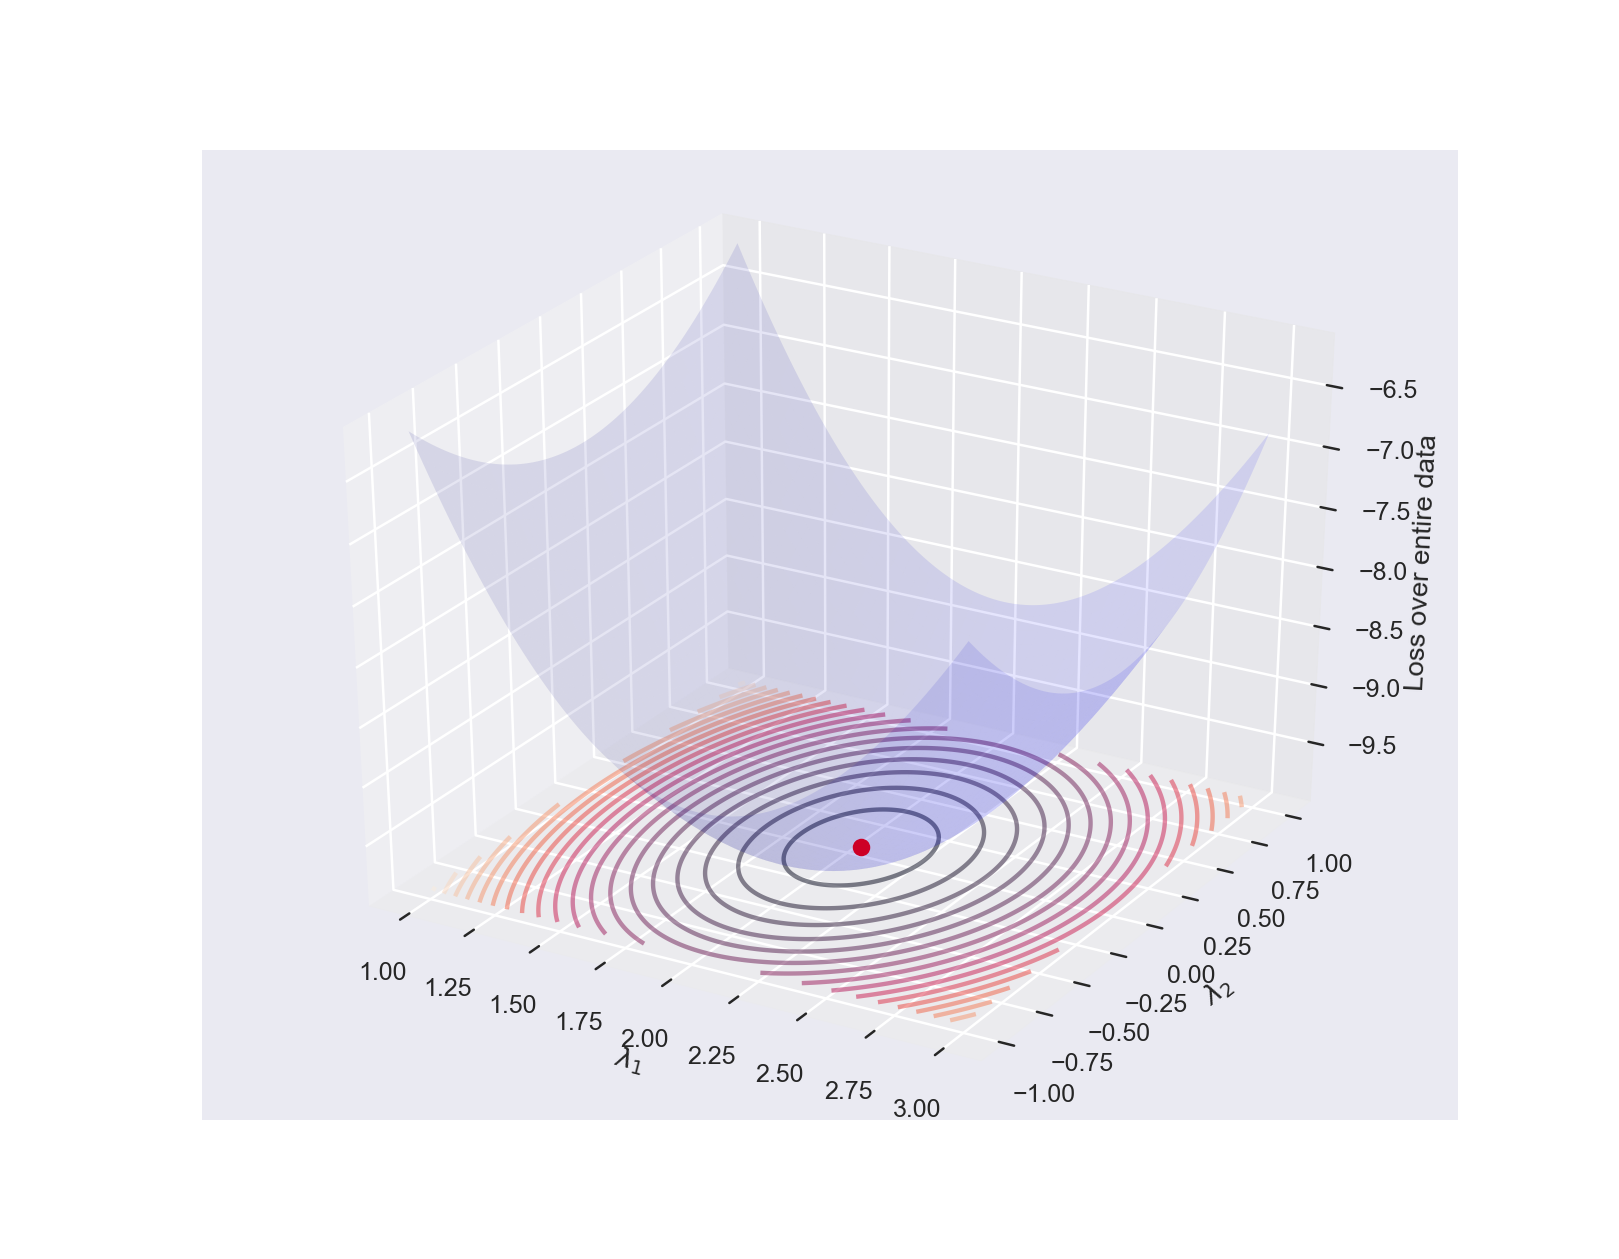

In [18]:
# Load in data
data = np.loadtxt('HW3_data.csv', delimiter=',')
data = data.T

# Visualize loss surface 
X = data[:,0]
Y = data[:,1]
lmd1_grid, lmd2_grid = np.meshgrid(np.linspace(1, 3, 200), np.linspace(-1, 1, 200))
loss_grid = np.zeros(lmd1_grid.shape)
for i in range(200):
    for j in range(200):
        loss_grid[i,j] = loss(X, Y, lmd1_grid[i, j], lmd2_grid[i, j])

min_loss = loss(X, Y, 2.05384, 0)

fig = plt.figure(figsize=(9,7))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(lmd1_grid, lmd2_grid, loss_grid, color='b', alpha=0.1)
ax.contour(lmd1_grid, lmd2_grid, loss_grid, 20, offset=min_loss, color='b', alpha=0.5)
ax.plot([2.05384], [0], [min_loss], markerfacecolor='r', markeredgecolor='r', marker='o', markersize=7)
ax.set_xlabel(r'$\lambda_1$')
ax.set_ylabel(r'$\lambda_2$')
ax.set_zlabel('Loss over entire data')
plt.show()

From the loss surface visualization we can verify that the loss function is minimized for the given data for $\lambda_1 = 2.05384, \lambda_2 = 0$. 

In [4]:
# Implement gradient descent (adapted from sample code given in lecture)
def gradient_descent(x, y, lmd_init, lr=0.001, maxsteps=0, precision=0.001):
    
    # To store all losses and parameters 
    loss_history = []
    lmd_history = [] 
    
    # Initial set up 
    counter = 0
    lmd = lmd_init
    current_loss = loss(x, y, lmd[0], lmd[1])
    
    # Save initial results
    lmd_history.append(lmd)
    loss_history.append(current_loss)
    
    counter += 1
    
    # Do gradient descent update while the diff. between current loss and known minmum loss is above precision
    while abs(current_loss - min_loss) > precision:

        # Update parameters, compute new loss over entire dataset 
        gradient = loss_grad(x, y, lmd[0], lmd[1])
        lmd = lmd - lr * gradient
        current_loss = loss(x, y, lmd[0], lmd[1])
        
        # Save results 
        lmd_history.append(lmd)
        loss_history.append(current_loss)
         
        counter+=1
        
        # Stop gradient descent when the maximum num of steps is achieved  
        if maxsteps:
            if counter == maxsteps:
                break
        
    return loss_history, lmd_history, counter


# Implement stochastic gradient descent (adapted from sample code given in lecture)
def stochastic_gradient_descent(x, y, lmd_init, lr=0.001, maxsteps=0, precision=0.001):
    
    # To store all losses and parameters 
    loss_history = []
    lmd_history = [] 
    
    # Number of data points
    m = y.size 
    
    # Initial set up 
    counter = 0
    lmd = lmd_init
    current_loss = loss(x, y, lmd[0], lmd[1])
    old_loss = 0
    i = 0 # index of data point
    
    # Save initial results 
    loss_history.append(current_loss)
    lmd_history.append(lmd)
    
    counter += 1
    
    # Do gradient descent update while the diff. between current loss and known minmum loss is above precision
#     while abs(current_loss - old_loss) > precision:
    while abs(current_loss - min_loss) > precision:
        old_loss = current_loss
        
        # Update parameters using gradient evaluation of one data point, scaled with the dataset size 
        gradient = loss_grad(x[i], y[i], lmd[0], lmd[1])
        lmd = lmd - lr * gradient * m
        
        # Compute new loss over entire dataset 
        current_loss = loss(x, y, lmd[0], lmd[1])
        
        # Save results 
        loss_history.append(current_loss)
        lmd_history.append(lmd)

        counter += 1
        
        i += 1
        if i == m: # reached one past the end
            i = 0
            neworder = np.random.permutation(m)
            x = x[neworder]
            y = y[neworder]
            
        if maxsteps:
            if counter == maxsteps:
                break
        
    return loss_history, lmd_history, counter

***

### Part B
- Compare the average time it takes to update the parameter estimation in each iteration of the two implementations. Which method is faster? Briefly explain why this result should be expected.
- Compare the number of iterations it takes for each algorithm to obtain an estimate accurate to `1e-3` (you may wish to set a cap for maximum number of iterations). Which method converges to the optimal point in fewer iterations? Briefly explain why this result should be expected.

***

### *Solution*

In [5]:
lmd_init = np.array([1,1])

t0 = time.time()
loss_history_gd, lmd_history_gd, counter_gd = gradient_descent(X, Y, 
                                                               lmd_init, 
                                                               lr=0.0001, 
                                                               precision=0.001)
print('Average time: %.5f' % ((time.time()-t0)/counter_gd))
print('Number of iterations: %s' % counter_gd)

Average time: 0.00104
Number of iterations: 14522


In [6]:
neworder = np.random.permutation(X.size)
X_shuffled = X[neworder]
Y_shuffled = Y[neworder]

t0 = time.time()
loss_history_sgd, lmd_history_sgd, counter_sgd = stochastic_gradient_descent(X_shuffled, 
                                                                             Y_shuffled, 
                                                                             lmd_init, 
                                                                             lr=0.0001,
                                                                             maxsteps=1000000,
                                                                             precision=0.001)
print('Average time: %.5f' % ((time.time()-t0)/counter_sgd))
print('Number of iterations: %s' % counter_sgd)

Average time: 0.00029
Number of iterations: 323


<IPython.core.display.Javascript object>


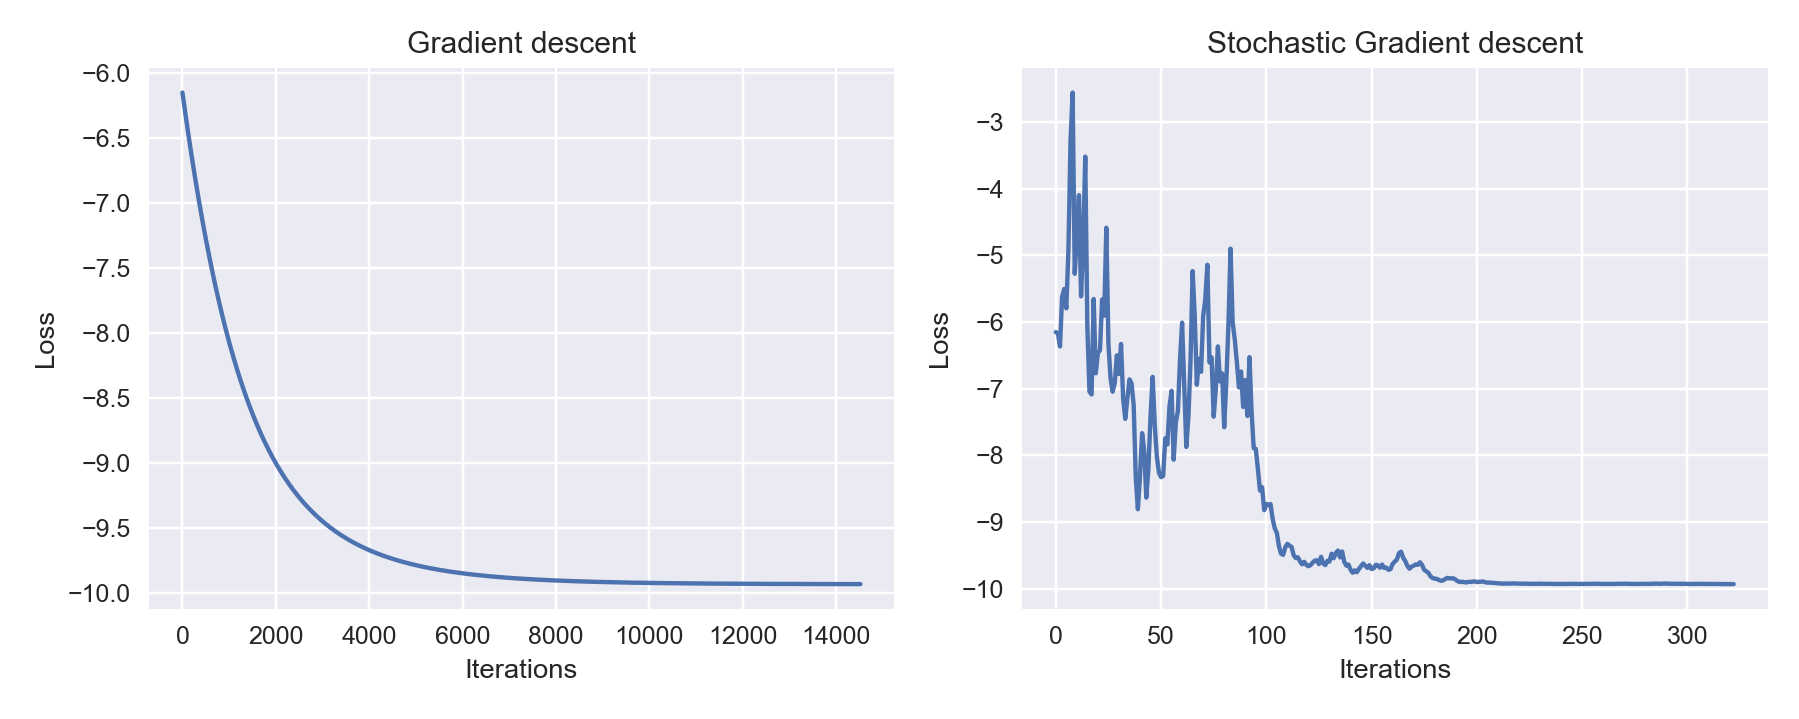

In [16]:
fig = plt.figure(figsize=(10, 4))
ax = fig.add_subplot(121)
ax.plot(loss_history_gd)
ax.set_xlabel('Iterations')
ax.set_ylabel('Loss')
ax.set_title('Gradient descent')
ax = fig.add_subplot(122)
ax.plot(loss_history_sgd)
ax.set_xlabel('Iterations')
ax.set_ylabel('Loss')
ax.set_title('Stochastic Gradient descent')
plt.tight_layout()
plt.show()

Based on the results, SGD is faster than GD in each iteration and converges to the optimal point in fewer iterations when we use the same learning rate=0.0001 and precision=0.001. This can be understood because each iteration of GD calculates the gradient on the entire dataset, while each iteration of SGD calculates the gradient on a single data point. That SGD converges in few iterations is expected because SGD follows a stochastic path rather than a smooth path to the optimal point. It is possible that SGD gets close to the optimal point with the same level of precision as GD in fewer iterations. 
***

### Part C
Compare the performance of stochastic gradient descent for the following learning rates: 1, 0.1, 0.001, 0.0001. Based on your observations, briefly describe the effect of the choice of learning rate on the performance of the algorithm.

***

### *Solution*

In [8]:
loss_history_sgd1, lmd_history_sgd1, counter_sgd1 = stochastic_gradient_descent(X_shuffled, 
                                                                             Y_shuffled, 
                                                                             lmd_init, 
                                                                             lr=0.0001,
                                                                             maxsteps=100000,
                                                                             precision=0.001)

In [9]:
loss_history_sgd2, lmd_history_sgd2, counter_sgd2 = stochastic_gradient_descent(X_shuffled, 
                                                                             Y_shuffled, 
                                                                             lmd_init, 
                                                                             lr=0.001,
                                                                             maxsteps=100000,
                                                                             precision=0.001)

<IPython.core.display.Javascript object>


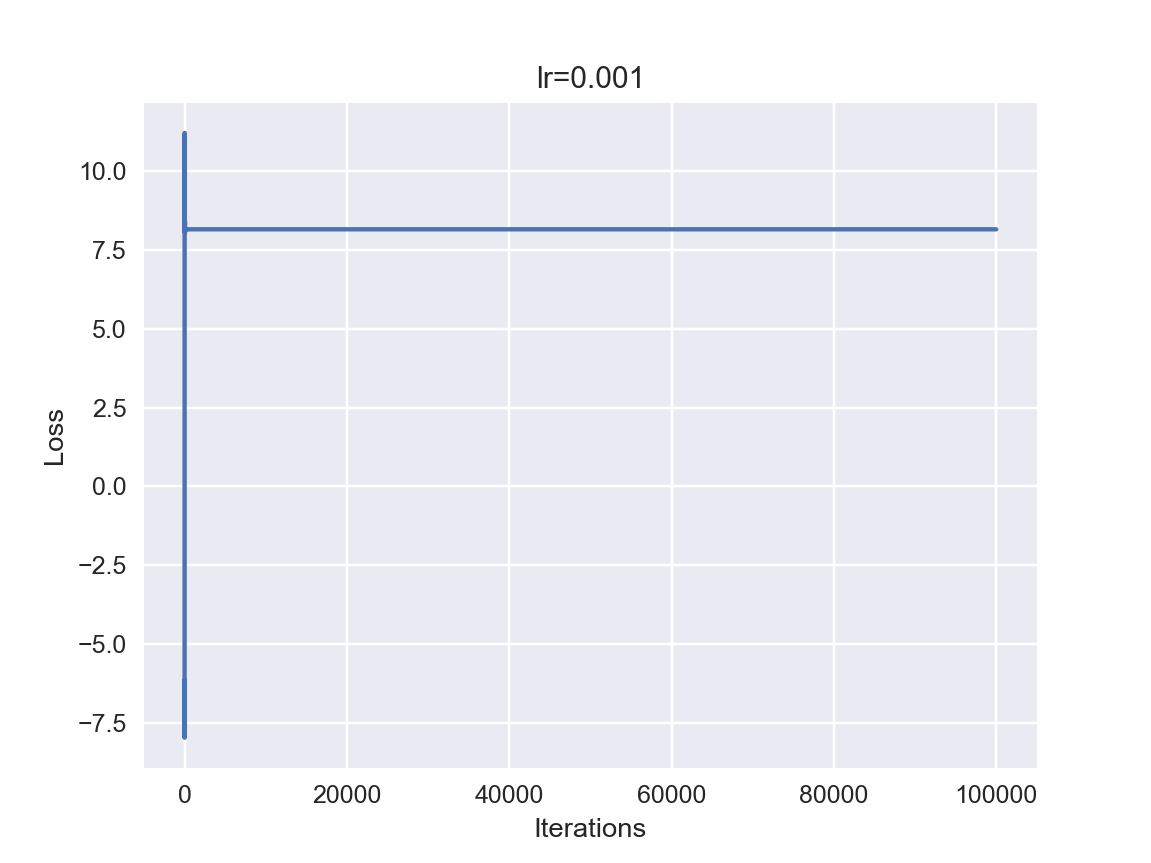

In [17]:
plt.figure()
plt.plot(loss_history_sgd2)
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.title('lr=0.001')
plt.show()

In [13]:
loss_history_sgd3, lmd_history_sgd3, counter_sgd3 = stochastic_gradient_descent(X_shuffled, 
                                                                             Y_shuffled, 
                                                                             lmd_init, 
                                                                             lr=0.01,
                                                                             maxsteps=100000,
                                                                             precision=0.001)

/Users/rfang/anaconda/envs/snakes/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: overflow encountered in double_scalars
  This is separate from the ipykernel package so we can avoid doing imports until


In [14]:
loss_history_sgd4, lmd_history_sgd4, counter_sgd4 = stochastic_gradient_descent(X_shuffled, 
                                                                             Y_shuffled, 
                                                                             lmd_init, 
                                                                             lr=0.1,
                                                                             maxsteps=100000,
                                                                             precision=0.001)

/Users/rfang/anaconda/envs/snakes/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: overflow encountered in double_scalars
  This is separate from the ipykernel package so we can avoid doing imports until


In [15]:
loss_history_sgd5, lmd_history_sgd5, counter_sgd5 = stochastic_gradient_descent(X_shuffled, 
                                                                             Y_shuffled, 
                                                                             lmd_init, 
                                                                             lr=1,
                                                                             maxsteps=100000,
                                                                             precision=0.001)

/Users/rfang/anaconda/envs/snakes/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: overflow encountered in double_scalars
  This is separate from the ipykernel package so we can avoid doing imports until


The performance of SGD is good when lr=0.0001, but not when lr=0.001, 0.01, 0.1, 1. Based on the observations, SGD is only able to find a global minimum when learning rate is smaller than a certain threshold. The loss will be stuck in a different local minimum if the learning rate is slightly bigger than the threshold (in this case lr=0.001 is an example). If learning rate is too big, each update would be too big such that the loss increases rapidly (lr=0.01, 0.1, 1). 

***

## Problem 2. SGD for Multinomial Logistic Regresion on MNIST

The [*MNIST* dataset](https://en.wikipedia.org/wiki/MNIST_database) is one of the classic datasets in Machine Learning and is often one of the first datasets against which new classification algorithms test themselves.  It consists of 70,000 images of handwritten digits, each of which is 28x28 pixels. You will be using PyTorch to build a handwritten digit classifier that you will train and test with MNIST. 

** The MNIST dataset (including a train/test split which you must use) is part of PyTorch in the torchvision module.  The Lab will have details of how to load it. **

Your classifier must implement a multinomial logistic regression model (using softmax). It will take as input an array of pixel values in an image and output the images most likely digit label (i.e. 0-9). You should think of the pixel values as features of the input vector.  

1. Plot 10 sample images from the MNIST dataset (to develop intuition for the feature space).
2. Construct a softmax formulation in PyTorch of multinomial logistic regression with Cross Entropy Loss.
3. Train your model using SGD to minimize the cost function. *Use a batch size of 64, a learning rate $\eta = 0.01$, and 10 epochs*.
4. Plot the cross-entropy loss on the training set as a function of iteration.
5. What are the training and test set accuracies?  
6. Plot some (around 5) examples of misclassifications.




***

### *Solution*

In [19]:
import torch
import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as dset
from torch.autograd import Variable
import torch.nn as nn

In [20]:
root = './data'
train_set = dset.MNIST(root=root, train=True, transform=transforms.ToTensor(), download=True)
test_set = dset.MNIST(root=root, train=False, transform=transforms.ToTensor(), download=True)

<IPython.core.display.Javascript object>


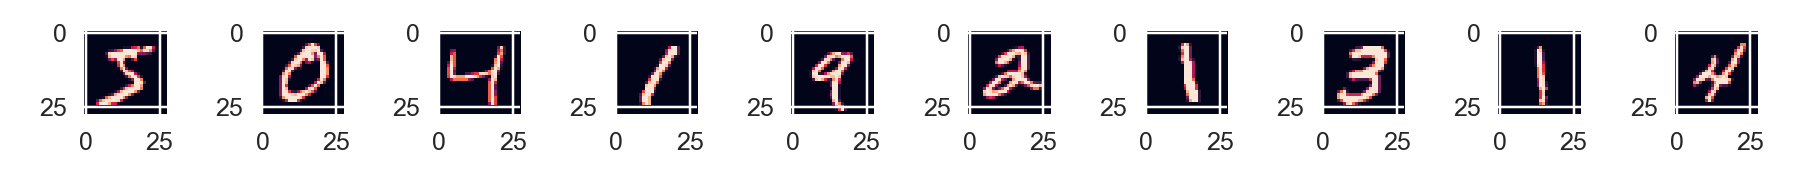

In [21]:
# Plot 10 sample images from the MNIST dataset
fig, axes = plt.subplots(1, 10, figsize=(10, 1))

for i in range(10):
    inputs, target = train_set[i]
    axes[i].imshow(inputs.numpy()[0])
plt.tight_layout()
plt.show()

In [23]:
# A classifier using multinomial logistic regression model (referenced lab3 and piazza hints)

# Define multinomial logistic regression model
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.linear = nn.Linear(784, 10)
    
    def forward(self, x):
        out = self.linear(x)
        return out

# Specify batch size, learning rate, number of epochs 
batch_size = 64
learning_rate = 0.01
num_epochs = 10

# To save history of loss 
loss_history = []

# Construct model 
model = Model()

# Construct loss function and optimizer
criterion = nn.CrossEntropyLoss()  
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)  

# Load training and set data 
train_loader = torch.utils.data.DataLoader(dataset=train_set, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_set, batch_size=batch_size, shuffle=False)

# Train the Model
for epoch in range(num_epochs):
    
    for batch_index, data in enumerate(train_loader):

        # Convert data, target into Variables
        inputs, labels = data
        inputs = Variable(inputs)
        labels = Variable(labels)

        # Resize data from (batch_size,1, 28, 28) ---> (batch_size, 784)
        inputs = inputs.view(-1, 784)
        
        # Forward pass
        outputs = model(inputs)
        
        # Compute and save loss 
        loss = criterion(outputs, labels)
        loss_history.append(loss.data[0])
        
        # Zero gradients, perform a backward pass, and update the weights
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

<IPython.core.display.Javascript object>


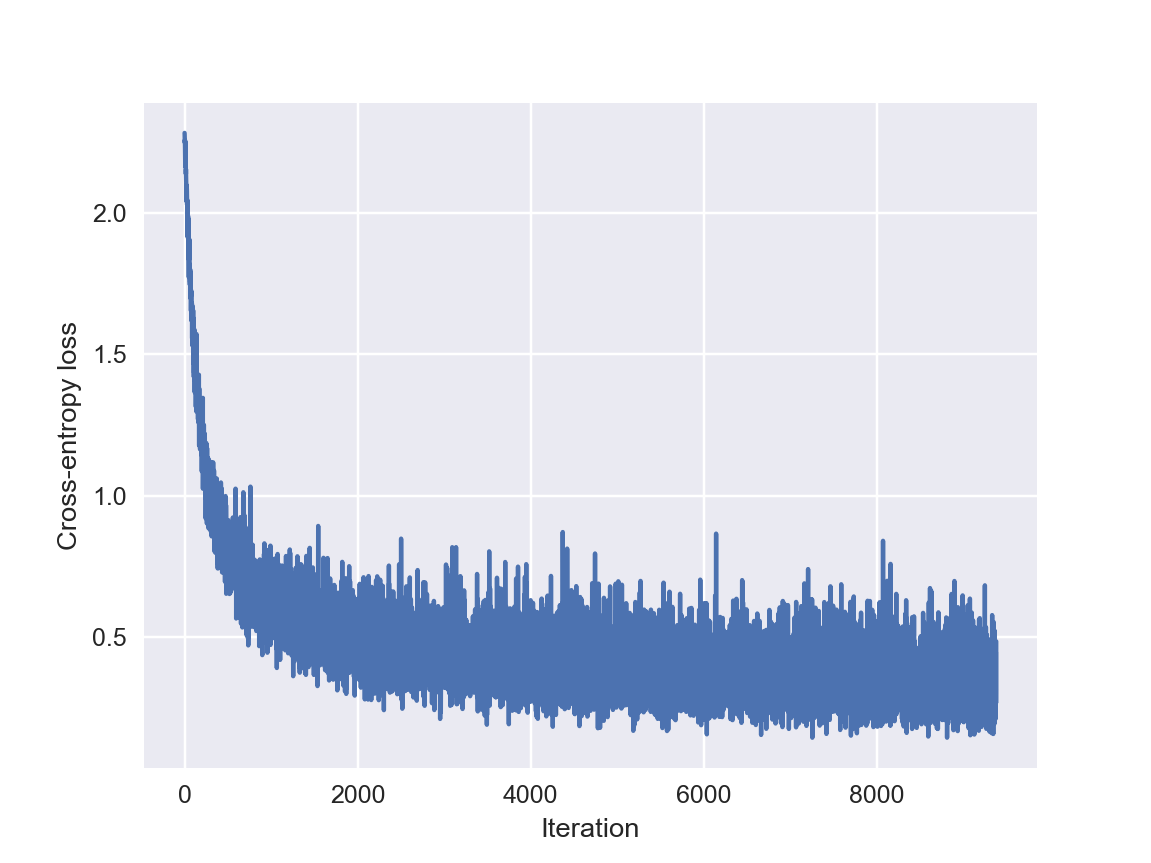

In [24]:
# Plot the cross-entropy loss on the training set as a function of iteration
plt.figure()
plt.plot(loss_history)
plt.xlabel('Iteration')
plt.ylabel('Cross-entropy loss')
plt.show()

In [25]:
# Compute training and test data accuracy 
train_set_correct = 0
test_set_correct = 0

for data in train_loader:

    inputs, labels = data
    outputs = model(Variable(inputs).view(-1, 784))
    _, predicted = torch.max(outputs.data, 1)
    
    train_set_correct += (predicted == labels).sum()

# To store indices of misclassifications 
test_set_mis_index =[]

for batch_index, data in enumerate(test_loader):

    inputs, labels = data
    outputs = model(Variable(inputs).view(-1, 784))
    _, predicted = torch.max(outputs.data, 1)
    
    test_set_correct += (predicted == labels).sum()
    
    mis_index_this_batch = batch_index*batch_size + np.nonzero((predicted != labels).numpy())[0]
    test_set_mis_index.extend(mis_index_this_batch)

print("Training set accuracy = %.3f" % (train_set_correct/len(train_set)))
print("Test set accuracy = %.3f" % (test_set_correct/len(test_set)))

Training set accuracy = 0.903
Test set accuracy = 0.910


<IPython.core.display.Javascript object>


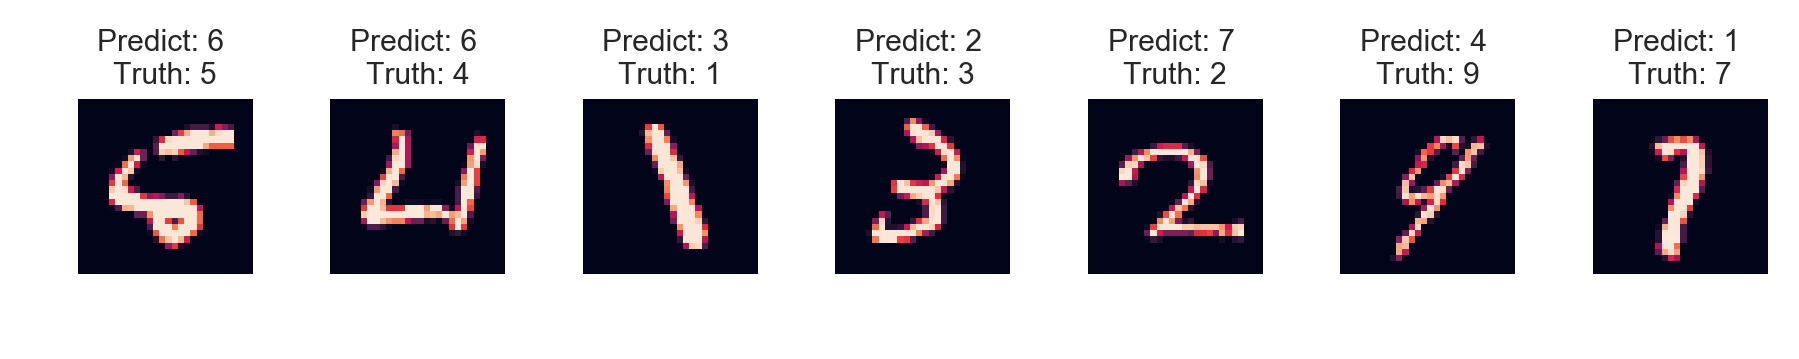

In [26]:
# Plot examples of misclassifications
fig, axes = plt.subplots(1, 7, figsize=(10, 2))

for c, i in enumerate(test_set_mis_index[:7]):
    
    inputs, label = test_set[i]
    outputs = model(Variable(inputs).view(-1, 784))
    _, predicted = torch.max(outputs.data, 1)
    
    axes[c].imshow(inputs.numpy()[0])
    axes[c].axis('off')
    axes[c].set_title("Predict: %s \nTruth: %s" % (predicted.numpy()[0], label))

plt.tight_layout()
plt.show()

***